In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
from time import sleep

In [2]:
class Particle:

    def __init__(self,r0,v0,a0,f0 ,t,m=1,radius=2,Id=0):

        self.dt = t[1] - t[0]

        self.r = r0
        self.v = v0
        self.a = a0
        self.f = f0
        self.m = m
        self.Id = Id


        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        self.F = np.zeros_like(self.R)

        self.radius = radius

    def Contact_Force(self, other):
        R1 = self.radius
        R2 = other.radius
        r1 = self.r
        r2 = other.r
        m = self.m
        K = 1 / pow(m, 3)
        n = r1 - r2
        norm = np.linalg.norm(n)

        if norm < R1 + R2:
            return -K*pow(norm, 3) * n / norm
        else:
            return 0
    
    def Colition(self, other):
        force = self.Contact_Force(other)
        if np.isscalar(force) == False:
            self.f = force
            self.a = self.f/self.m
        
    def Evolution(self, i, other=None):

        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetAcceleration(i)
        self.SetForce(i)

        self.r += self.v*self.dt
        self.v += self.a*self.dt
        self.a = 0
        self.f = 0

    def SetPosition(self,i):
        self.R[i] = self.r

    def GetPosition(self,scale=1):
        return self.R[::scale]

    def SetVelocity(self,i):
        self.V[i] = self.v

    def GetVelocity(self,scale=1):
        return self.V[::scale]

    def SetAcceleration(self,i):
        self.A[i] = self.a

    def GetAcceleration(self,scale=1):
        return self.A[::scale]

    def SetForce(self,i):
        self.F[i] = self.f

    def GetForce(self,scale=1):
        return self.F[::scale]

    def CheckLimits(self,Limits):

        for i in range(2):

            if self.r[i] + self.radius > Limits[i][1] and self.v[i] > 0.:
                self.v[i] = -1.0*self.v[i]
            if self.r[i] - self.radius < Limits[i][0] and self.v[i] < 0.:
                self.v[i] = -1.0*self.v[i]

In [3]:
def RunSimulation1(t,Wall):
    
    r0_1 = np.array([-15.,1.])
    v0_1 = np.array([10.,0.])
    a0_1 = np.array([0.,0.])
    f0_1 = np.array([0.,0.])

    r0_2 = np.array([0.,-1.5])
    v0_2 = np.array([0.,0.])
    a0_2 = np.array([0.,0.])
    f0_2 = np.array([0.,0.])
    
    
    p1 = Particle(r0_1, v0_1, a0_1, f0_1, t)
    p2 = Particle(r0_2, v0_2, a0_2, f0_2, t)
    
    Wall_ = Wall.copy()
    
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps'):
        sleep(0.0001)
        p1.Evolution(it, p2)
        p2.Evolution(it, p1)
        p1.CheckLimits(Wall_)
        p2.CheckLimits(Wall_)
        p1.Colition(p2)
        p2.Colition(p1)
    
    return np.array([p1, p2])

In [4]:
# Region
Limits = np.array([[-16.,16.],[-16.,16.]])
Limits

array([[-16.,  16.],
       [-16.,  16.]])

In [5]:
dt = 0.05
tmax = 10
t = np.arange(0.,tmax,dt)
Particles = RunSimulation1(t,Limits)

Running simulation: 100%|██████████| 200/200 [00:00<00:00, 4700.84 Steps/s]


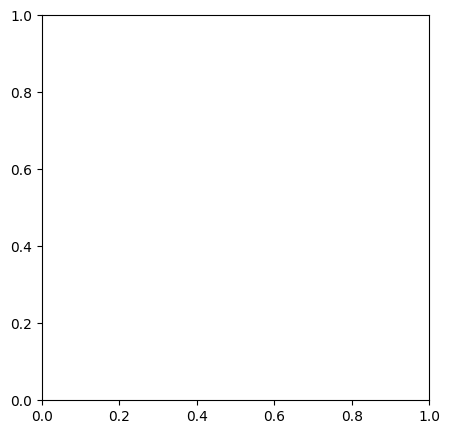

In [6]:
scale = 1

t = t[::scale]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)


def init():
    ax.set_xlim(Limits[0][0], Limits[0][1])
    ax.set_ylim(Limits[1][0], Limits[1][1])


def Update(i):

    ax.clear()
    init()
    ax.set_title(r'$ t=%.2f \ s$' % (t[i]))

    x1, x2 = Particles[0].GetPosition(scale)[i, 0], Particles[1].GetPosition(scale)[i, 0]
    y1, y2 = Particles[0].GetPosition(scale)[i, 1], Particles[1].GetPosition(scale)[i, 1]
    vx1, vx2 = Particles[0].GetVelocity(scale)[i, 0], Particles[1].GetVelocity(scale)[i, 0]
    vy1, vy2 = Particles[0].GetVelocity(scale)[i, 1], Particles[1].GetVelocity(scale)[i, 1]
    p1_radius, p2_radius = Particles[0].radius, Particles[1].radius

    circle = plt.Circle((x1, y1), p1_radius, fill=True, color='k')
    circle2 = plt.Circle((x2, y2), p2_radius, fill=True, color='k')
    ax.add_patch(circle)
    ax.add_patch(circle2)

    ax.arrow(x1,
             y1,
             vx1,
             vy1,
             color='r',
             head_width=0.2,
             length_includes_head=True)
    ax.arrow(x2,
                y2,
                vx2,
                vy2,
                color='r',
                head_width=0.2,
                length_includes_head=True)


Animation = anim.FuncAnimation(fig, Update, frames=len(t), init_func=init)
plt.show()


In [7]:
Writer = anim.writers['ffmpeg']
fps = (1. / dt) / scale
writer_ = Writer(fps=fps, metadata=dict(artist='Me'))
Animation.save('Particula.mp4', writer=writer_)
